In [1]:
import cvxpy as cp
import numpy as np
import pdb
from tqdm import tqdm

class FW:
    def __init__(self, constraint_var, constraints, H, A, h, u_bar):
      
        self.constraint_var = constraint_var
        self.constraints = constraints
        self.H, self.A, self.h, self.u_bar = H, A, h, u_bar
        self.n = H.shape[1]
        self.m = A.shape[0]

    def project(self, constraints, grad):

        x = self.constraint_var
        objective = cp.Maximize(cp.scalar_product(x, grad)) 
        prob = cp.Problem(objective, constraints)
        prob.solve() 
        return x.value


    def stochastic_continuous_greedy_step(self, x, grad, epoch, alpha):
       
        s = np.zeros_like(grad)
        
        for i in range(s.shape[0]):
            s[i] = self.project( self.constraints, grad[i])
        
        
        return (1- alpha)*x + alpha*s 

    
    def compute_value_grad(self, x, noise_scale=10):
        noise = np.random.normal(scale=noise_scale, size=x.shape)
        
        value = 1/2*x @ self.H @ x.T + self.h.T @ x.T
        gradient = self.H@x.T + self.h
        
        return value[0][0], gradient + noise
    
    
    def stochastic_continuous_greedy(self, epoch, weight_shape):

        x = np.zeros(shape=weight_shape) + 1e-5
        values = []
        for e in tqdm(range(epoch)):
            alpha = (0.1 / (e + 1))
            #print(alpha)
            value, grad = self.compute_value_grad(x)
            x = self.stochastic_continuous_greedy_step(x, grad, epoch, alpha)
            values.append(value)

        return values 

In [2]:
Val = []
run = 100
for i in range(run):
    n = 10
    m = 50
    b = 10
    u_bar = np.ones((1,n))
    H = np.random.uniform(-100, 0, (n, n))
    A = np.random.uniform(0, 1, (m, n))
    h = -1 * H.T @ u_bar.T
    train_iter = 300
    x = cp.Variable(shape=(1,n))
    constraints = [0 <= x, x <= u_bar, A @ x.T <= b]
    fw = FW(x, constraints, H, A, h, u_bar)
    values = fw.stochastic_continuous_greedy(train_iter, (1,n))
    Val.append(values)

100%|█████████████████████████████████████████| 300/300 [00:13<00:00, 22.42it/s]


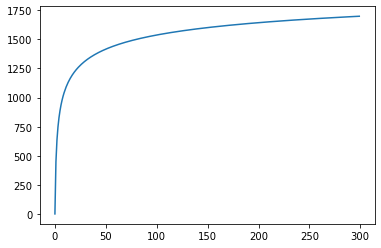

In [3]:
import matplotlib.pyplot as plt
plt.figure()
#plt.axis([0, 50, -2500, 2500])
plt.plot(values)
plt.show()

In [4]:
data = np.array(Val)
average = np.average(data, axis=0)
minimum = np.min(np.array(Val), axis=0) 

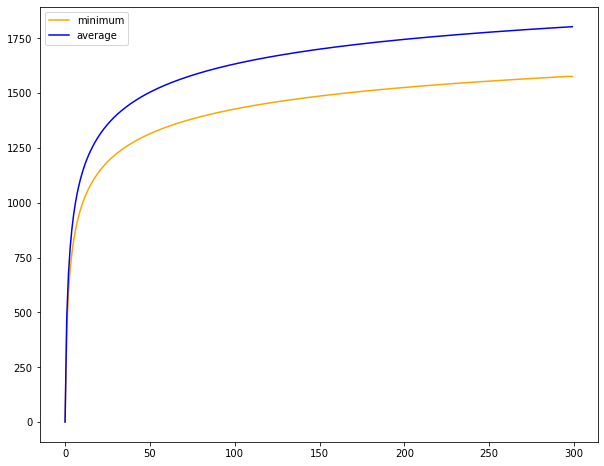

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(minimum, color='orange', label='minimum')
plt.plot(average, color='blue', label= 'average')
plt.legend(loc="upper left")
plt.show()

In [6]:
from scipy import stats
r, f = stats.pearsonr(average, minimum)
print(f"P-correlation {r}")

P-correlation 0.9999987990147075
